In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from sklearn.svm import SVC
from torchvision import transforms

In [2]:
# def load_images(images_folder, save_file_to=None):
#     X_original = []
#     X = []
#     y = []
    
#     for subdir, dirs, files in os.walk(images_folder):
#         for file in files:
#             if file.endswith(('jpg', 'jpeg', 'png')):
#                 img_path = os.path.join(subdir, file)
#                 label = os.path.basename(subdir)
                
#                 image = Image.open(img_path).convert('L')
#                 image = image.resize((48, 48))
#                 X_original.append(np.array(image).flatten())
#                 X.append(np.array(image).flatten())
#                 y.append(label)
                
#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_original, X, y), f, protocol=5)
                
#     return np.array(X_original), np.array(X), np.array(y)

# # Load images and save the dataset for reuse
# images_folder = '../images'
# dataset_file = "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/final/dataset_dump.pkl"

# X_original, X, y = load_images(images_folder, save_file_to=dataset_file)


In [3]:
with open("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/final/dataset_dump.pkl"
, "rb") as f:
    X_original, X, y = load(f)


In [4]:

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [5]:
def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  # Normalize to [0, 1]
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Dimensionality reduction with PCA
    pca = PCA(n_components=100)
    X_reduced = pca.fit_transform(X)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reduced)
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, pca, scaler), f, protocol=5)
    
    return X_scaled, y_encoded, label_encoder, pca, scaler

X_scaled, y_encoded, label_encoder, pca, scaler = preprocessing_data(X, y, save_file_to="labelencoder_standardscaler_pca_normalizers_dump.pkl")


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [7]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [8]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, len(np.unique(y_encoded)))

    def forward(self, x):
        # Apply ReLU activation after each layer
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first layer
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))  # Apply ReLU after third layer
        x = self.fc4(x)  # Output layer
        return x


In [9]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'num_epochs': [500, 1000],  # Example: try 500 and 1000 epochs
    'learning_rate': [0.001, 0.0005],  # Example: try different learning rates
    'batch_size': [32, 64],  # Example: try different batch sizes
}

# Grid search to try each combination of parameters
grid = ParameterGrid(param_grid)

# Loop through each combination of parameters
for params in grid:
    print(f"Training with parameters: {params}")
    
    # Extract parameters
    num_epochs = params['num_epochs']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']

    # Redefine the model, optimizer, and criterion for each combination
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model with the current combination of hyperparameters
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        # Split data into batches
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model after training
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        print(f'Accuracy: {accuracy * 100:.2f}%')

        # Print classification report
        report = classification_report(y_test_tensor, predicted, target_names=label_encoder.classes_)
        print(f"Classification Report:\n{report}")

    print("\n" + "-"*50 + "\n")

Training with parameters: {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 500}
Epoch [100/500], Loss: 1.8465
Epoch [200/500], Loss: 1.8189
Epoch [300/500], Loss: 1.8322
Epoch [400/500], Loss: 1.8059
Epoch [500/500], Loss: 1.8045
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------

Training with parameters: {'batch_size': 32, 'learning_rate': 0.001, 'nu

C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/1000], Loss: 1.8498
Epoch [200/1000], Loss: 1.7325
Epoch [300/1000], Loss: 1.8190
Epoch [400/1000], Loss: 1.7650
Epoch [500/1000], Loss: 1.8128
Epoch [600/1000], Loss: 1.9152
Epoch [700/1000], Loss: 1.7987
Epoch [800/1000], Loss: 1.7703
Epoch [900/1000], Loss: 1.8246
Epoch [1000/1000], Loss: 1.8295
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/500], Loss: 1.9018
Epoch [200/500], Loss: 1.8796
Epoch [300/500], Loss: 1.8612
Epoch [400/500], Loss: 1.8750
Epoch [500/500], Loss: 1.9124
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------

Training with parameters: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 1000}


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/1000], Loss: 1.8379
Epoch [200/1000], Loss: 1.7934
Epoch [300/1000], Loss: 1.8526
Epoch [400/1000], Loss: 1.8398
Epoch [500/1000], Loss: 1.8634
Epoch [600/1000], Loss: 1.8580
Epoch [700/1000], Loss: 1.8488
Epoch [800/1000], Loss: 1.8646
Epoch [900/1000], Loss: 1.8330
Epoch [1000/1000], Loss: 1.8446
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/500], Loss: 1.8574
Epoch [200/500], Loss: 1.8718
Epoch [300/500], Loss: 1.9031
Epoch [400/500], Loss: 1.8677
Epoch [500/500], Loss: 1.8388
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------

Training with parameters: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000}


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/1000], Loss: 1.9072
Epoch [200/1000], Loss: 1.8124
Epoch [300/1000], Loss: 1.8322
Epoch [400/1000], Loss: 1.8601
Epoch [500/1000], Loss: 1.8387
Epoch [600/1000], Loss: 1.8567
Epoch [700/1000], Loss: 1.8617
Epoch [800/1000], Loss: 1.8762
Epoch [900/1000], Loss: 1.8894
Epoch [1000/1000], Loss: 1.8687
Accuracy: 25.01%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.00      0.00      0.00      1600

    accuracy                           0.25     14355
   macro avg       0.04      0.14      0.06     14355
weighted avg       0.06      0.25      0.10     14355


--------------------------------------------------


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/500], Loss: 1.9865
Epoch [200/500], Loss: 1.9151
Epoch [300/500], Loss: 1.8584
Epoch [400/500], Loss: 1.8121
Epoch [500/500], Loss: 1.8380
Accuracy: 25.20%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.61      0.22      0.33      3590
     neutral       0.19      0.94      0.31      2504
         sad       0.25      0.00      0.00      2417
    surprise       0.98      0.28      0.44      1600

    accuracy                           0.25     14355
   macro avg       0.29      0.21      0.15     14355
weighted avg       0.34      0.25      0.19     14355


--------------------------------------------------

Training with parameters: {'batch_size': 64, 'learning_rate': 0.0005, 'num_epochs': 1000}


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [100/1000], Loss: 1.9841
Epoch [200/1000], Loss: 1.9363
Epoch [300/1000], Loss: 1.8370
Epoch [400/1000], Loss: 1.8836
Epoch [500/1000], Loss: 1.8566
Epoch [600/1000], Loss: 1.8761
Epoch [700/1000], Loss: 1.9270
Epoch [800/1000], Loss: 1.8589
Epoch [900/1000], Loss: 1.8654
Epoch [1000/1000], Loss: 1.8537
Accuracy: 25.69%
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1963
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00      2064
       happy       0.25      1.00      0.40      3590
     neutral       0.00      0.00      0.00      2504
         sad       0.00      0.00      0.00      2417
    surprise       0.72      0.07      0.12      1600

    accuracy                           0.26     14355
   macro avg       0.14      0.15      0.07     14355
weighted avg       0.14      0.26      0.11     14355


--------------------------------------------------


C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

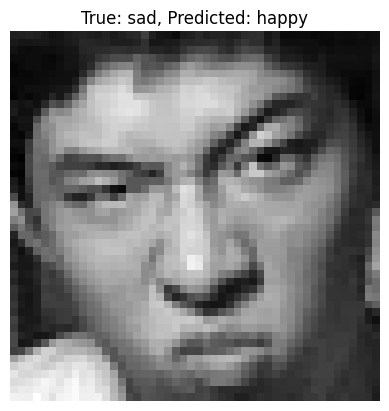

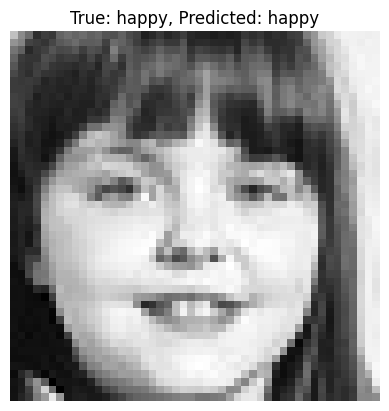

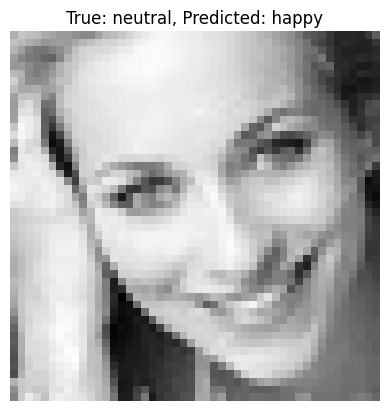

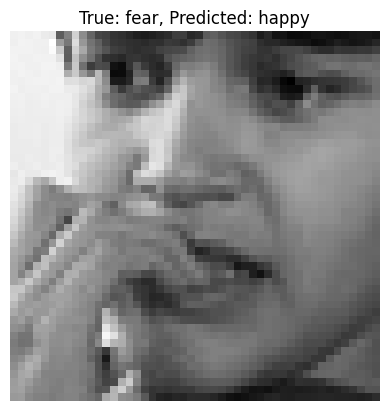

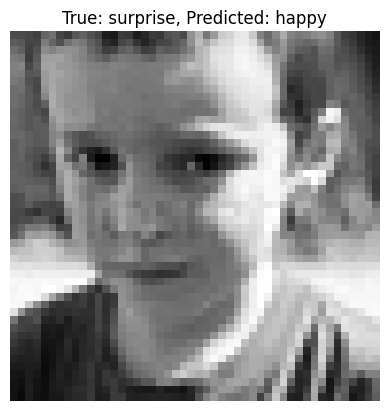

In [10]:
# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs.data, 1)
    
    random_indices = np.random.randint(0, len(y_test), 5)
    
    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape to 48x48
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

visualize_predictions(model, X_test_tensor, y_test_tensor, label_encoder, X_original)